# check oof df

In [13]:
import os

import numpy as np
import pandas as pd
from pandarallel import pandarallel
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


In [14]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

In [15]:
output_dir = os.path.join("/kaggle", "working")
# exp_name = "baseline000"
exp_name = "baseline000_1697037446.0796616"
oof_df_path = os.path.join(output_dir, exp_name,"oof_df.parquet")
oof_df = pd.read_parquet(oof_df_path)

In [16]:
oof_df.columns

Index(['series_id', 'series_date_key', 'timestamp', 'date', 'time', 'step',
       'anglez', 'enmo', 'event', 'event_onset', 'event_wakeup', 'class_pred',
       'class_target', 'event_pred'],
      dtype='object')

In [17]:
oof_df.head()

,series_id,series_date_key,timestamp,date,time,step,anglez,enmo,event,event_onset,event_wakeup,class_pred,class_target,event_pred
1081800,1087d7b0ff2e,1087d7b0ff2e_2018-03-13,2018-03-13 13:15:00,2018-03-13,13:15:00,0,-87.805298,0.0227,0.0,0,0,0.158813,0.0,-0.0
1081801,1087d7b0ff2e,1087d7b0ff2e_2018-03-13,2018-03-13 13:15:05,2018-03-13,13:15:05,1,-87.803802,0.0224,0.0,0,0,0.183350,0.0,-0.0
1081802,1087d7b0ff2e,1087d7b0ff2e_2018-03-13,2018-03-13 13:15:10,2018-03-13,13:15:10,2,-87.798897,0.0225,0.0,0,0,0.204956,0.0,-0.0
1081803,1087d7b0ff2e,1087d7b0ff2e_2018-03-13,2018-03-13 13:15:15,2018-03-13,13:15:15,3,-87.804802,0.0232,0.0,0,0,0.226929,0.0,-0.0
1081804,1087d7b0ff2e,1087d7b0ff2e_2018-03-13,2018-03-13 13:15:20,2018-03-13,13:15:20,4,-87.799896,0.0232,0.0,0,0,0.248291,0.0,0.0


In [39]:
# postprocess_fn
# series_idでgroupbyして、class_predに対して対象の列のデータから前のN個の列までのデータの平均をとる
import torch
import torch.nn as nn

# 1step 0.5secで30minなら60*30=1800step
def postprocess_fn(df, N=1800, maxpool_kernel_size=101, maxpool_stride=1):
    df = df.copy()
    df["class_pred_beforemean"] = df.groupby("series_id")["class_pred"].apply(lambda x: x.rolling(N, min_periods=1).mean())
    df["class_pred_aftermean"] = df.groupby("series_id")["class_pred"].apply(lambda x: x[::-1].rolling(N, min_periods=1).mean()[::-1])
    df["event_pred"] = df["class_pred_beforemean"] - df["class_pred_aftermean"]

    # 入力サイズと出力サイズが一致するようにpaddingを調整
    maxpool_padding = int((maxpool_kernel_size - maxpool_stride) / 2)
    # maxpoolしてピーク検出
    max_pooling = nn.MaxPool1d(maxpool_kernel_size, stride=maxpool_stride, padding=maxpool_padding)
    event_pred = df["event_pred"].values
    event_pred = torch.tensor(event_pred).unsqueeze(0)
    pooled_event_pred = max_pooling(np.abs(event_pred)).squeeze(0).numpy()
    event_pred = event_pred.squeeze(0).numpy()
    # peakのところだけ残すmaskを作成
    peak_event_pred_mask = np.where(pooled_event_pred == np.abs(event_pred), 1, 0)
    peak_event_pred = event_pred * peak_event_pred_mask
    df["event_pred"] = peak_event_pred
    df = df.drop(["class_pred_beforemean", "class_pred_aftermean"], axis=1)
    return df


def make_submission_df(df, threshold=0.1):
    df = df[["series_id", "step", "event_pred"]].copy()
    # thresholdより大きいときは1,-thresholdより小さいときは-1,それ以外は0
    df["event"] = df["event_pred"].apply(lambda x: 1 if x > threshold else -1 if x < -threshold else 0)
    df = df[df["event"] != 0].copy()
    df["event"] = df["event"].replace({1: "wakeup", -1: "onset"})
    df["score"] = df["event_pred"].apply(lambda x: np.clip(np.abs(x), 0.0, 1.0))
    return df


In [40]:
df = postprocess_fn(oof_df, N=1200)
sub_df = make_submission_df(df, threshold=0.2)

2322173
2517688
1806127
1288775
879235


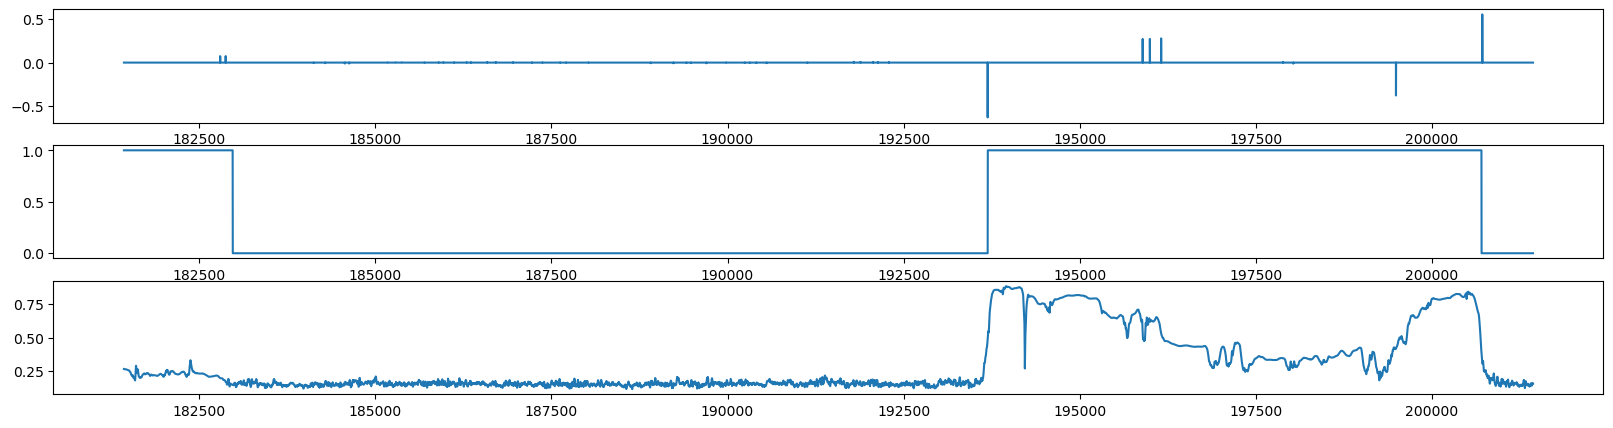

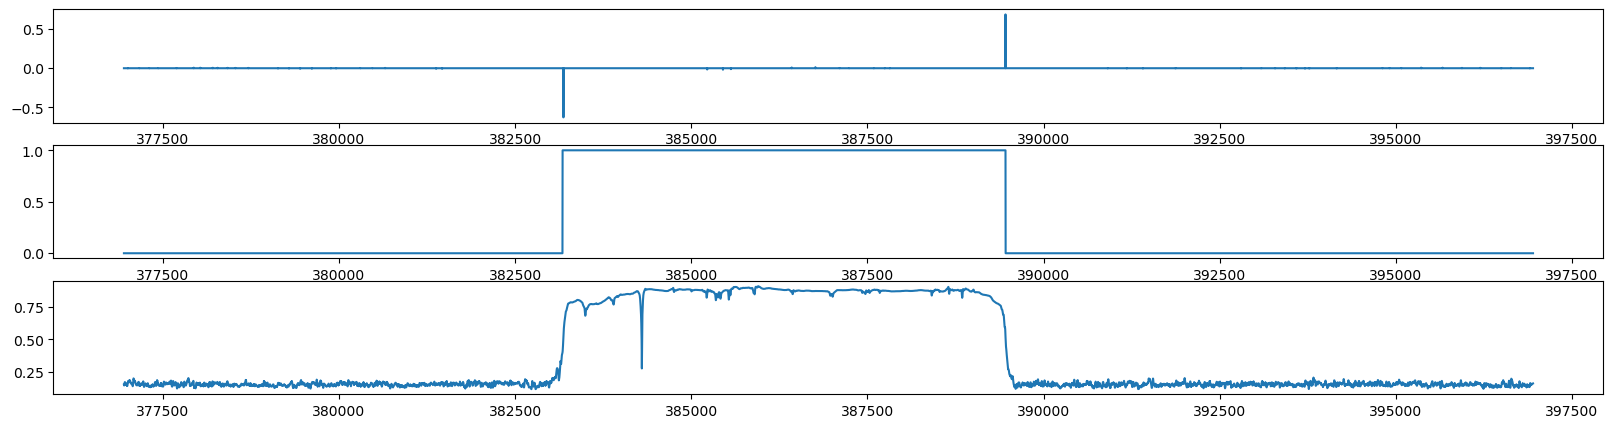

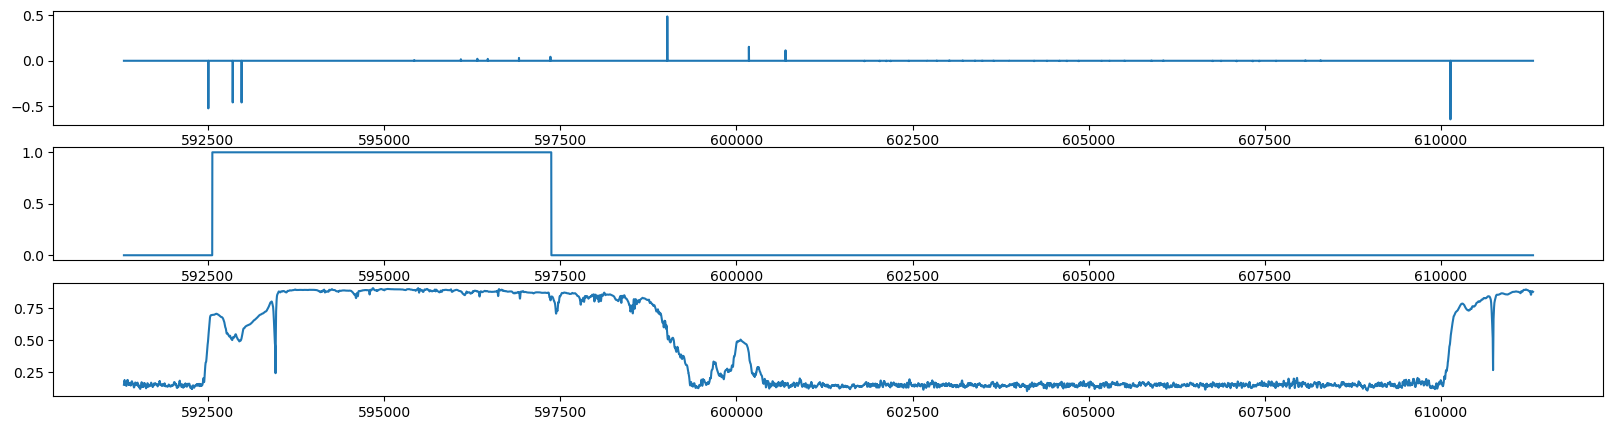

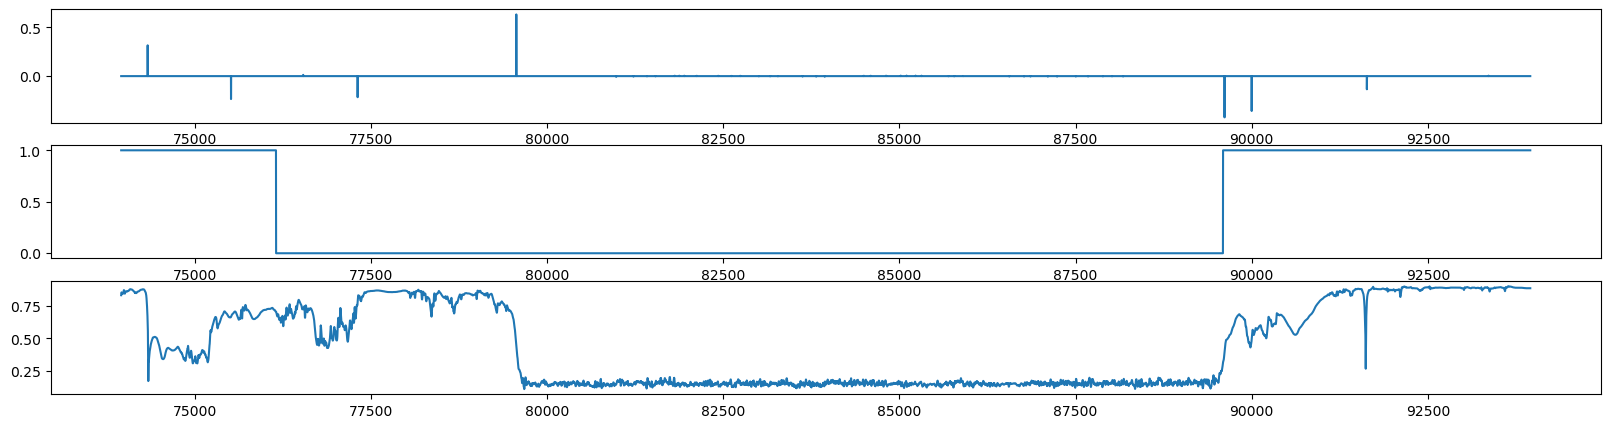

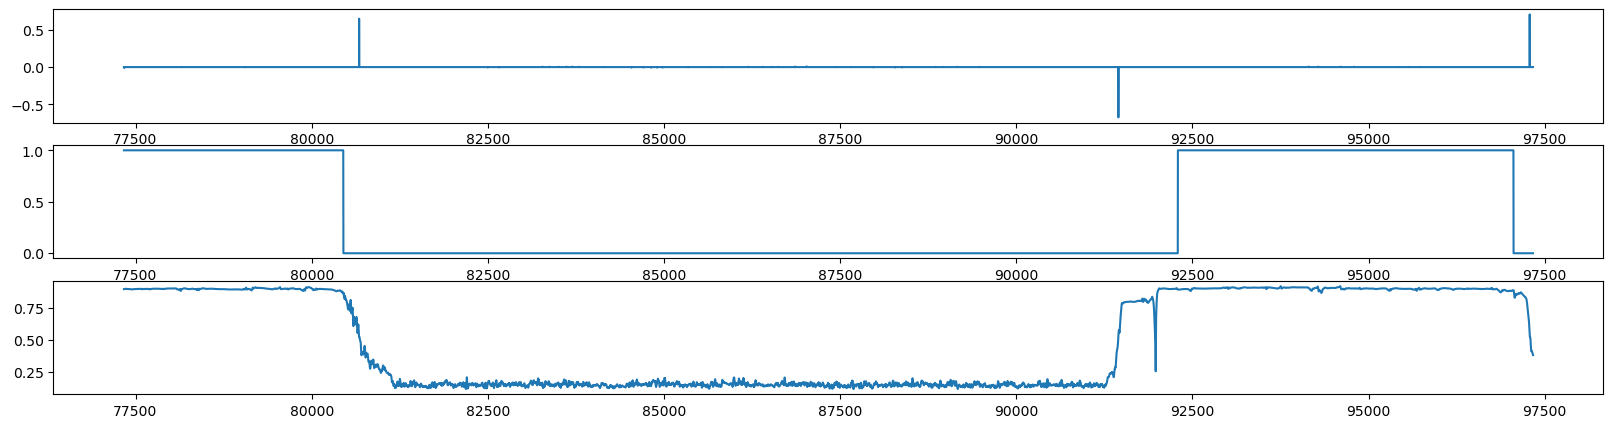

In [41]:
data_num = 20000
for _ in range(5):
    random_num = np.random.randint(0, len(df)-data_num)
    print(random_num)
    plt.figure(figsize=(20, 5))
    plt.subplot(3, 1, 1)
    plt.plot(df["step"].iloc[random_num:random_num+data_num], df["event_pred"].iloc[random_num:random_num+data_num], label="class_pred")
    plt.subplot(3, 1, 2)
    plt.plot(df["step"].iloc[random_num:random_num+data_num], df["event"].iloc[random_num:random_num+data_num], label="event_pred")
    plt.subplot(3, 1, 3)
    plt.plot(df["step"].iloc[random_num:random_num+data_num], df["class_pred"].iloc[random_num:random_num+data_num], label="class_pred")


In [42]:
train_event_df = pd.read_csv("/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv")
train_event_df = train_event_df[train_event_df["series_id"].isin(df["series_id"].unique())].copy()
train_event_df = train_event_df.reset_index(drop=True)
display(train_event_df.head())

,series_id,night,event,step,timestamp
0,1087d7b0ff2e,1,onset,7368.0,2018-03-13T23:29:00-0500
1,1087d7b0ff2e,1,wakeup,12876.0,2018-03-14T07:08:00-0500
2,1087d7b0ff2e,2,onset,20292.0,2018-03-14T17:26:00-0500
3,1087d7b0ff2e,2,wakeup,29916.0,2018-03-15T06:48:00-0500
4,1087d7b0ff2e,3,onset,41676.0,2018-03-15T23:08:00-0500


In [43]:
sub_df.head()

,series_id,step,event_pred,event,score
1089159,1087d7b0ff2e,7359,-0.629425,onset,0.629425
1089543,1087d7b0ff2e,7743,-0.581381,onset,0.581381
1094662,1087d7b0ff2e,12862,0.715822,wakeup,0.715822
1101955,1087d7b0ff2e,20155,-0.669958,onset,0.669958
1111081,1087d7b0ff2e,29281,0.513165,wakeup,0.513165


In [44]:
import sys
sys.path.append("/kaggle/src/dss_utils")

# series_id_column_name = "series_id"
# time_column_name = "step"
# event_column_name = "event"
# score_column_name = "score"
# use_scoring_intervals = None  # type:ignore


# # [1, 3, 5, 7, 10, 13, 15, 20, 25, 30] minute
# tolerances = {
#     "onset": [12, 36, 60, 90, 120, 150, 180, 240, 300, 360],
#     "wakeup": [12, 36, 60, 90, 120, 150, 180, 240, 300, 360],
# }

from dss_metrics import score
score(train_event_df, sub_df)

0.45490692063177285

In [45]:
for average_size in range(100, 1000, 100):
    df = postprocess_fn(oof_df, N=average_size)
    sub_df = make_submission_df(df, threshold=0.1)
    print(f"average_size: {average_size}")
    print(score(train_event_df, sub_df))

average_size: 100
0.47338100240665393
average_size: 200


0.5011503902591379
average_size: 300
0.49949624984825436
average_size: 400
0.49620173413956714
average_size: 500
0.48909004017069324
average_size: 600
0.4855331292973375
average_size: 700
0.47253638574141915
average_size: 800
0.476465208406053
average_size: 900
0.4670415231976633
